# Calculate PPA performance
## Maria Jacob
In this notebook we want to
* explore the various datasets provided

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Exploring data sets

## Wind forecast

In [3]:
wind_forecast = pd.read_csv("2018_2022_national_wind_forecast_data.csv")
wind_forecast

,delivery_from,forecast_timestamp,day_ahead_national_forecast,national_wind_capacity
0,2018-04-16 23:00:00+00:00,2018-04-19 08:05:35+00:00,7523.656150,11173.25
1,2018-04-16 23:30:00+00:00,2018-04-19 08:05:35+00:00,7656.137150,11173.25
2,2018-04-17 00:00:00+00:00,2018-04-19 08:05:35+00:00,7736.733183,11173.25
3,2018-04-17 00:30:00+00:00,2018-04-19 08:05:35+00:00,7765.444248,11173.25
4,2018-04-17 01:00:00+00:00,2018-04-19 08:05:35+00:00,7852.161290,11173.25
...,...,...,...,...
74581,2022-07-19 20:30:00+00:00,2022-07-18 07:22:37+00:00,5951.000000,15635.00
74582,2022-07-19 21:00:00+00:00,2022-07-18 07:22:37+00:00,5806.000000,15635.00
74583,2022-07-19 21:30:00+00:00,2022-07-18 07:22:37+00:00,5644.000000,15635.00
74584,2022-07-19 22:00:00+00:00,2022-07-18 07:22:37+00:00,5458.000000,15635.00


In [4]:
(wind_forecast["delivery_from"] < wind_forecast["forecast_timestamp"]).sum()

163

In [5]:
(wind_forecast["delivery_from"] >= wind_forecast["forecast_timestamp"]).sum()

74423

In [6]:
wind_forecast["forecast_timestamp"].unique()

array(['2018-04-19 08:05:35+00:00', '2018-04-19 08:05:14+00:00',
       '2018-04-19 08:04:59+00:00', ..., '2022-07-16 07:22:58+00:00',
       '2022-07-17 07:22:50+00:00', '2022-07-18 07:22:37+00:00'],
      dtype=object)

In [7]:
wind_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74586 entries, 0 to 74585
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   delivery_from                74586 non-null  object 
 1   forecast_timestamp           74586 non-null  object 
 2   day_ahead_national_forecast  74586 non-null  float64
 3   national_wind_capacity       74586 non-null  float64
dtypes: float64(2), object(2)
memory usage: 2.3+ MB


### Fixing data types

In [8]:
wind_forecast["delivery_from"] = pd.to_datetime(wind_forecast["delivery_from"])

In [9]:
wind_forecast["forecast_timestamp"] = pd.to_datetime(wind_forecast["forecast_timestamp"])

In [10]:
wind_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74586 entries, 0 to 74585
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   delivery_from                74586 non-null  datetime64[ns, UTC]
 1   forecast_timestamp           74586 non-null  datetime64[ns, UTC]
 2   day_ahead_national_forecast  74586 non-null  float64            
 3   national_wind_capacity       74586 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(2)
memory usage: 2.3 MB


### check data quality: illogical date times

There seemed to be some rows (163) where `delivery_from` was before the `forecast_timestamp` which can't be right. I'll remove them since there are so few but something to check

In [11]:
wind_forecast = wind_forecast.loc[wind_forecast["delivery_from"]>=wind_forecast["forecast_timestamp"]].copy()

In [12]:
print(
    "Earliest delivery forecast: ",wind_forecast["delivery_from"].dt.date.min(),
    "\nLatest delivery forecast: ",wind_forecast["delivery_from"].dt.date.max(),
    "\nNumber of days: ",wind_forecast["delivery_from"].dt.date.nunique(),
    f"\nSo there are {int(wind_forecast["delivery_from"].dt.date.nunique()/365)}+ years of forecasts"
)

Earliest delivery forecast:  2018-04-19 
Latest delivery forecast:  2022-07-19 
Number of days:  1551 
So there are 4+ years of forecasts


### Missing or extreme values

In [13]:
wind_forecast.isna().sum()

delivery_from                  0
forecast_timestamp             0
day_ahead_national_forecast    0
national_wind_capacity         0
dtype: int64

Check for any extreme values (since none missing)

In [14]:
wind_forecast.describe()

,day_ahead_national_forecast,national_wind_capacity
count,74423.000000,74423.000000
mean,5244.945447,14325.827782
std,3503.767931,1571.343797
min,202.000000,1136.000000
25%,2245.000000,13347.000000
50%,4545.000000,15181.000000
75%,7805.000000,15594.000000
max,14138.000000,15730.000000


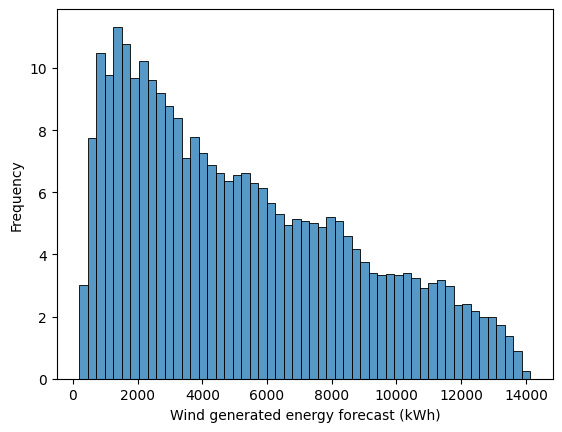

In [15]:
sns.histplot(
    data=wind_forecast,
    x="day_ahead_national_forecast",
    stat="frequency",
)
plt.xlabel("Wind generated energy forecast (kWh)")
plt.show()

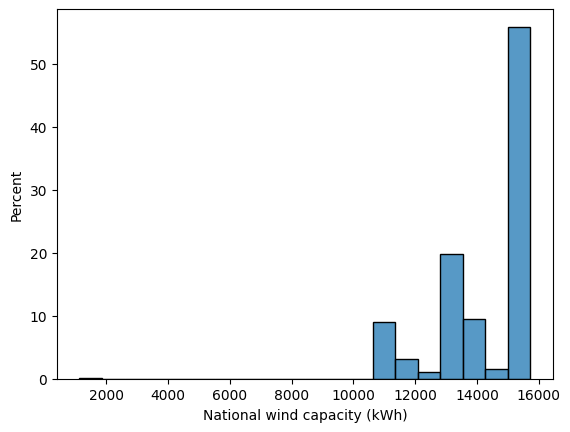

In [16]:
sns.histplot(
    data=wind_forecast,
    x="national_wind_capacity",
    stat="percent",
    bins=20,
)
plt.xlabel("National wind capacity (kWh)")
plt.show()

Doesn't seem to be any crazy values, though wind capapcity doesn't seem to be similar to wind generation forecast distributionally

### Duplicates
From above it seems like there is a day ahead forecast. Just checking there is only one day ahead forecast

In [17]:
num_forecasts_per_delivery_time = (
    wind_forecast
    .groupby("delivery_from")["forecast_timestamp"]
    .nunique()
    .rename("num_forecasts")
    .reset_index()
)
num_forecasts_per_delivery_time.head()

,delivery_from,num_forecasts
0,2018-04-19 08:30:00+00:00,1
1,2018-04-19 09:00:00+00:00,1
2,2018-04-19 09:30:00+00:00,1
3,2018-04-19 10:00:00+00:00,1
4,2018-04-19 10:30:00+00:00,1


In [18]:
num_forecasts_per_delivery_time["num_forecasts"].value_counts(normalize=True)

num_forecasts
1    0.998708
2    0.001292
Name: proportion, dtype: float64

There are some duplicate (less 0.1%) and there seems to be no particular dates or hours where this is true

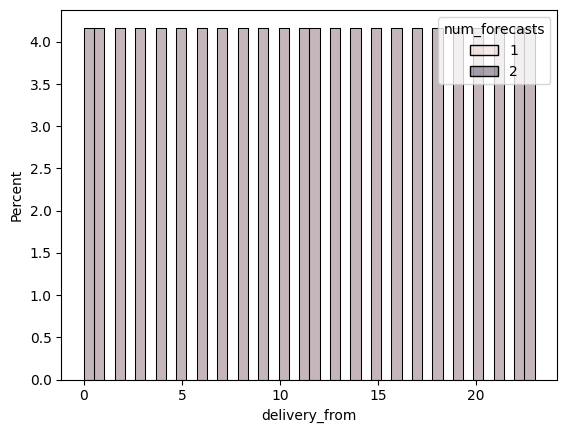

In [19]:
sns.histplot(
    data=num_forecasts_per_delivery_time,
    x=num_forecasts_per_delivery_time["delivery_from"].dt.hour,
    hue="num_forecasts",
    stat="percent",
    common_norm=False,
    alpha=0.4
)
plt.show()

In [20]:
wind_forecast[wind_forecast["delivery_from"]=="2020-01-23 22:30:00+00:00"]

,delivery_from,forecast_timestamp,day_ahead_national_forecast,national_wind_capacity
31049,2020-01-23 22:30:00+00:00,2020-01-22 09:15:55+00:00,2045.0,14215.0
31097,2020-01-23 22:30:00+00:00,2020-01-22 10:27:54+00:00,2791.0,14215.0


In [21]:
delivery_times_with_multiple_forecasts = (
    num_forecasts_per_delivery_time[
        num_forecasts_per_delivery_time["num_forecasts"]==2
    ]["delivery_from"]
)

In [22]:
qwe = (
    wind_forecast[wind_forecast["delivery_from"].isin(delivery_times_with_multiple_forecasts)]
    .groupby("delivery_from")["forecast_timestamp"]
    .agg(["max","min"])
)
qwe["time_between_forecasts"] = (qwe["max"] - qwe["min"])
qwe["time_between_forecasts"].agg(["min","max"])

min   0 days 01:11:59
max   0 days 01:43:36
Name: time_between_forecasts, dtype: timedelta64[ns]

In [23]:
qwe.shape

(96, 3)

In [24]:
del qwe

all forecasts are regenerated within an hour... Maybe just keep the latter one

In [25]:
wind_forecast.head()

,delivery_from,forecast_timestamp,day_ahead_national_forecast,national_wind_capacity
115,2018-04-19 08:30:00+00:00,2018-04-19 08:04:59+00:00,2957.0,10973.0
116,2018-04-19 09:00:00+00:00,2018-04-19 08:04:59+00:00,2800.0,10973.0
117,2018-04-19 09:30:00+00:00,2018-04-19 08:04:59+00:00,2697.0,10973.0
118,2018-04-19 10:00:00+00:00,2018-04-19 08:04:59+00:00,2587.0,10973.0
119,2018-04-19 10:30:00+00:00,2018-04-19 08:04:59+00:00,2469.0,10973.0


In [26]:
ids_of_most_recent_forecast = (
    wind_forecast
    .groupby("delivery_from")["forecast_timestamp"]
    .idxmax()
)
wind_forecast = wind_forecast.loc[ids_of_most_recent_forecast]

In [27]:
wind_forecast.shape

(74327, 4)

## Trends

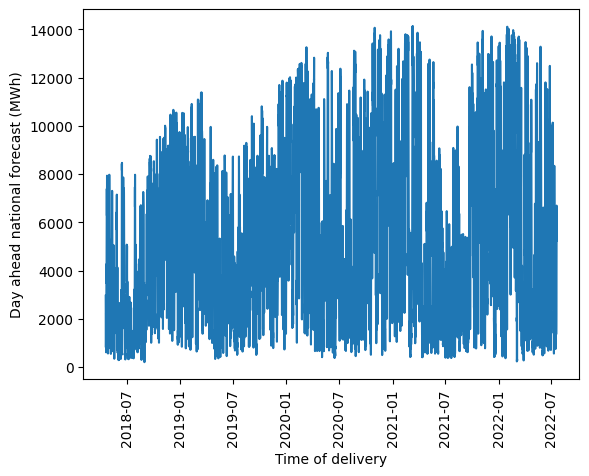

In [28]:
sns.lineplot(
    data = wind_forecast,
    x="delivery_from",
    y="day_ahead_national_forecast"
)
plt.xticks(rotation=90)
plt.xlabel("Time of delivery")
plt.ylabel("Day ahead national forecast (MWh)")
plt.show()

Lots of variability, very noisy!, let's do some grouping/smoothing

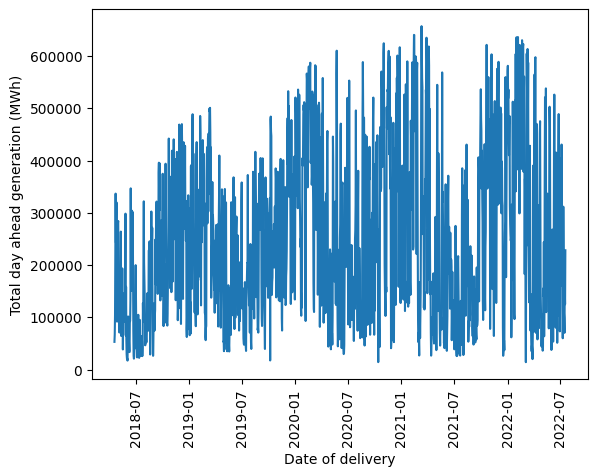

In [29]:
(
    wind_forecast
    .groupby(wind_forecast["delivery_from"].dt.date)["day_ahead_national_forecast"]
    .sum()
).plot(kind="line")
plt.xlabel("Date of delivery")
plt.ylabel("Total day ahead generation (MWh)")
plt.title
plt.xticks(rotation=90)
plt.show()

Very variable day to day!

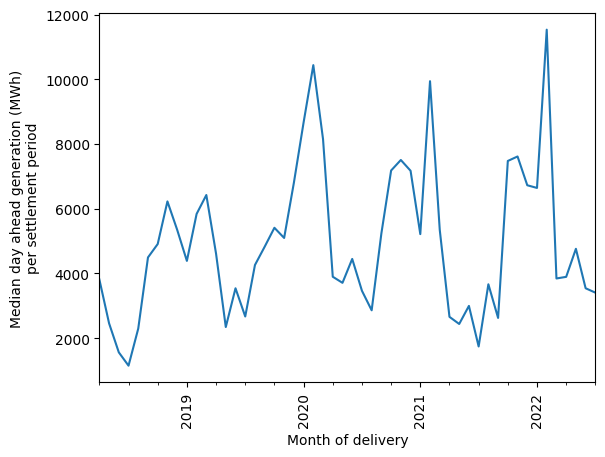

In [30]:
(
    wind_forecast
    .groupby(pd.Grouper(key="delivery_from",freq="1M"))["day_ahead_national_forecast"]
    .median()
).plot(kind="line")
plt.xlabel("Month of delivery")
plt.ylabel("Median day ahead generation (MWh)\nper settlement period")
plt.xticks(rotation=90)
plt.show()

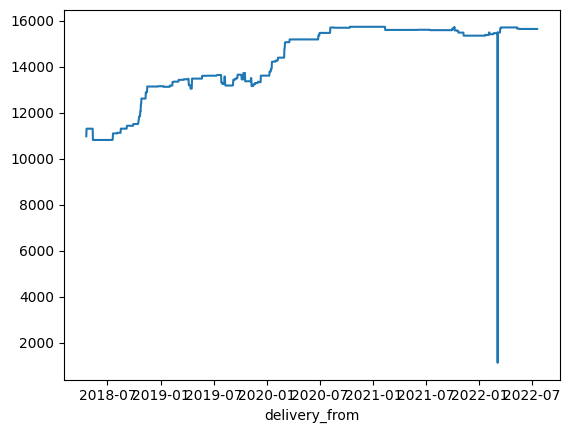

In [31]:
(
    wind_forecast
    .groupby(wind_forecast["delivery_from"].dt.date)["national_wind_capacity"]
    .median()
).plot(kind="line")
plt.show()

In general, 
* capacity is increasing (obviously), 
* much more stable than generated wind. 
* Can have periods of unchanging capacity... somehow when capapcity is high... does this indicate periods of high wind (I wouldn't expect them to last a few weeks...)  
* one very low value... is this an error?

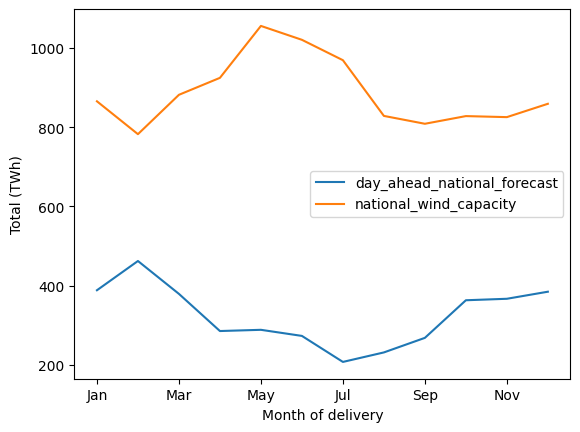

In [32]:
(
    wind_forecast
    .groupby(wind_forecast["delivery_from"].dt.month)[["day_ahead_national_forecast","national_wind_capacity"]]
    .sum()
    .div(100_000)
).plot(kind="line")
plt.xlabel("Month of delivery")
plt.ylabel("Total (TWh)")
plt.xticks(
    ticks=np.arange(1,13,2),
    labels=["Jan","Mar","May","Jul","Sep","Nov"],
)
plt.show()

Yikes the capacity is not matching on a monthly basis. Is there a good correlation between the two?

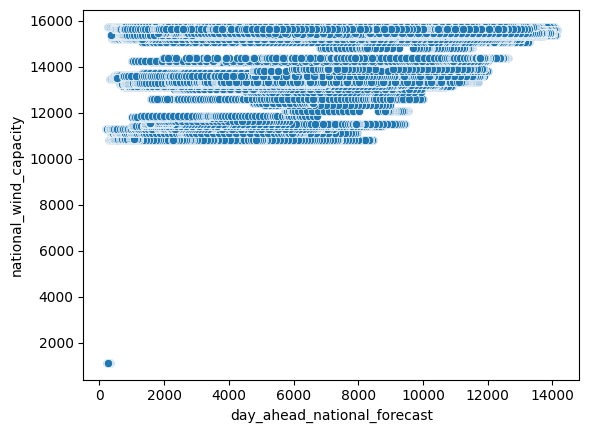

In [33]:
sns.scatterplot(
    data = wind_forecast,
    x="day_ahead_national_forecast",
    y="national_wind_capacity",
)
plt.show()

The capacity doesn't change per day... so let's look at this same plot at the daily level... also what are these values in the bottom left corner?? One day: 5th March 2022... wonder why

In [34]:
wind_forecast[
    (wind_forecast["day_ahead_national_forecast"].between(0,2000))
    &
    (wind_forecast["national_wind_capacity"].between(0,2000) )
]

,delivery_from,forecast_timestamp,day_ahead_national_forecast,national_wind_capacity
68012,2022-03-05 00:00:00+00:00,2022-03-04 07:19:24+00:00,233.0,1136.0
68013,2022-03-05 00:30:00+00:00,2022-03-04 07:19:24+00:00,242.0,1136.0
68014,2022-03-05 01:00:00+00:00,2022-03-04 07:19:24+00:00,249.0,1136.0
68015,2022-03-05 01:30:00+00:00,2022-03-04 07:19:24+00:00,255.0,1136.0
68016,2022-03-05 02:00:00+00:00,2022-03-04 07:19:24+00:00,261.0,1136.0
68017,2022-03-05 02:30:00+00:00,2022-03-04 07:19:24+00:00,268.0,1136.0
68018,2022-03-05 03:00:00+00:00,2022-03-04 07:19:24+00:00,276.0,1136.0
68019,2022-03-05 03:30:00+00:00,2022-03-04 07:19:24+00:00,286.0,1136.0
68020,2022-03-05 04:00:00+00:00,2022-03-04 07:19:24+00:00,292.0,1136.0
68021,2022-03-05 04:30:00+00:00,2022-03-04 07:19:24+00:00,293.0,1136.0


In [35]:
wind_forecast.columns

Index(['delivery_from', 'forecast_timestamp', 'day_ahead_national_forecast',
       'national_wind_capacity'],
      dtype='object')

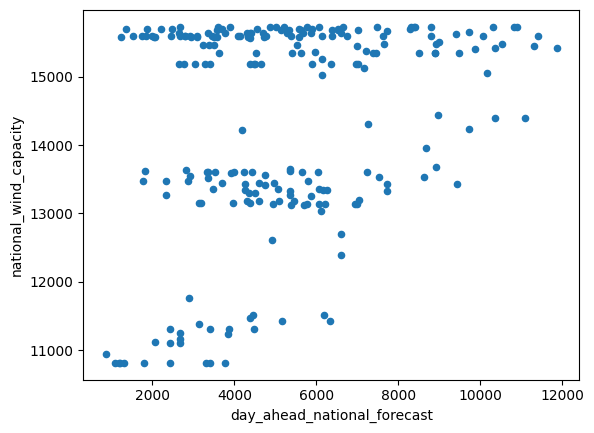

In [36]:
(
    wind_forecast
    .groupby(pd.Grouper(
        key="delivery_from",
        freq="1W"
    ))[["day_ahead_national_forecast","national_wind_capacity"]]
    .mean()
).plot(kind="scatter",y="national_wind_capacity",x="day_ahead_national_forecast")
plt.show()

In [37]:
(
    wind_forecast
    .groupby("national_wind_capacity")["delivery_from"]
    .nunique()
    .sort_values()
)

national_wind_capacity
10973.0      29
1136.0       48
13574.0      48
13550.0      48
13476.0      48
           ... 
15594.0    3358
15344.0    3600
15584.0    3696
15181.0    4750
15729.0    5378
Name: delivery_from, Length: 101, dtype: int64

capacity and generation are quite differently skewed

## wind generated

In [38]:
wind_generated = pd.read_csv("2018_2022_national_wind_generated_data.csv")
wind_generated.head()

,delivery_from,english_wind_generated,scottish_wind_generated,total_wind_generated
0,2018-03-31 23:00:00+00:00,1680.060,614.578,2294.638
1,2018-03-31 23:30:00+00:00,1625.204,560.996,2186.200
2,2018-04-01 00:00:00+00:00,1446.452,514.734,1961.186
3,2018-04-01 00:30:00+00:00,1273.264,466.560,1739.824
4,2018-04-01 01:00:00+00:00,1387.798,387.370,1775.168


In [40]:
(
    wind_generated
    .groupby(["delivery_from"])
    .size()
    .nlargest(5)
)

delivery_from
2018-03-31 23:00:00+00:00    1
2018-03-31 23:30:00+00:00    1
2018-04-01 00:00:00+00:00    1
2018-04-01 00:30:00+00:00    1
2018-04-01 01:00:00+00:00    1
dtype: int64

no duplicates, that's good

In [41]:
wind_generated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73008 entries, 0 to 73007
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   delivery_from            73008 non-null  object 
 1   english_wind_generated   73008 non-null  float64
 2   scottish_wind_generated  73008 non-null  float64
 3   total_wind_generated     73008 non-null  float64
dtypes: float64(3), object(1)
memory usage: 2.2+ MB


In [42]:
wind_generated["delivery_from"] = pd.to_datetime(wind_generated["delivery_from"])

In [43]:
print(
    "Earliest date: ", wind_generated["delivery_from"].dt.date.min(),
    "\nLatest date: ", wind_generated["delivery_from"].dt.date.max(),
    "\nNumber of dates: ", wind_generated["delivery_from"].dt.date.nunique()
)

Earliest date:  2018-03-31 
Latest date:  2022-05-30 
Number of dates:  1522


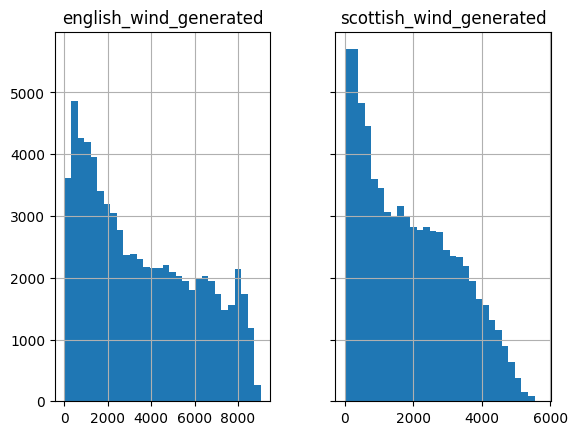

In [44]:
wind_generated[["english_wind_generated","scottish_wind_generated"]].hist(bins=30,sharey=True)
plt.show()

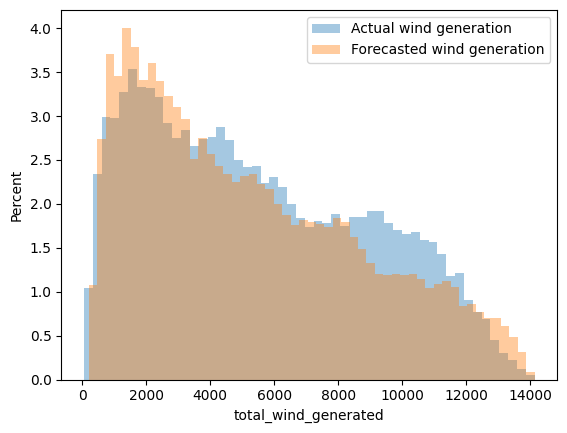

In [45]:
fig, ax = plt.subplots()
sns.histplot(
    data = wind_generated,
    x="total_wind_generated",
    ax=ax,
    label="Actual wind generation",
    stat="percent",
    alpha=0.4,
    edgecolor=None
)
sns.histplot(
    data=wind_forecast,
    x="day_ahead_national_forecast",
    stat="percent",
    ax=ax,
    label="Forecasted wind generation",
    alpha=0.4,
    edgecolor=None,
)
plt.legend()
plt.show()

Slight differences in distribution but overall quite good at predicting generation! Woohoo

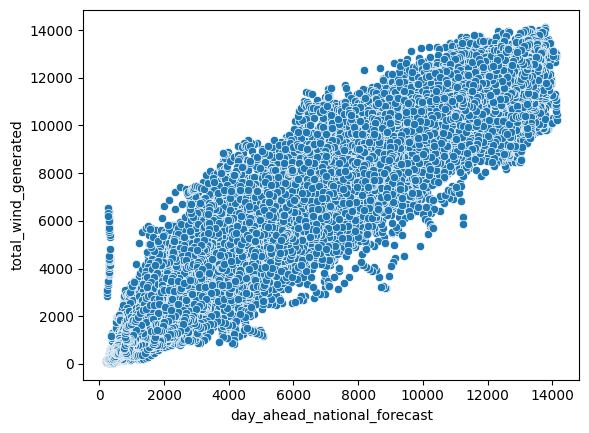

In [46]:
sns.scatterplot(
    data = pd.merge(wind_forecast,wind_generated,on="delivery_from"),
    x="day_ahead_national_forecast",
    y="total_wind_generated",
),
plt.show()

In [47]:
pd.merge(wind_forecast,wind_generated,on="delivery_from")[["day_ahead_national_forecast","total_wind_generated"]].corr()

,day_ahead_national_forecast,total_wind_generated
day_ahead_national_forecast,1.000000,0.956896
total_wind_generated,0.956896,1.000000


Yeah quite good correlation! Nice

# Spot prices

In [48]:
spot_prices = pd.read_csv("2018_2022_spot_price_data.csv")
spot_prices.head()

,delivery_from,day_ahead_half_hourly_auction_price,imbalance_price
0,2018-01-01 00:00:00+00:00,46.73,55.94
1,2018-01-01 00:30:00+00:00,50.11,55.94
2,2018-01-01 01:00:00+00:00,56.60,62.94
3,2018-01-01 01:30:00+00:00,51.83,31.00
4,2018-01-01 02:00:00+00:00,46.23,60.81


## Data cleaning
### Correct data types

In [49]:
spot_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77377 entries, 0 to 77376
Data columns (total 3 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   delivery_from                        77377 non-null  object 
 1   day_ahead_half_hourly_auction_price  77377 non-null  float64
 2   imbalance_price                      77377 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.8+ MB


In [50]:
spot_prices["delivery_from"] = pd.to_datetime(spot_prices["delivery_from"])

### Missing or odd values
doesn't look like there is any missing values from above. We wouldn't expect lots of negative values for prices either but it is possible! So let's double check

In [51]:
spot_prices.isna().sum()

delivery_from                          0
day_ahead_half_hourly_auction_price    0
imbalance_price                        0
dtype: int64

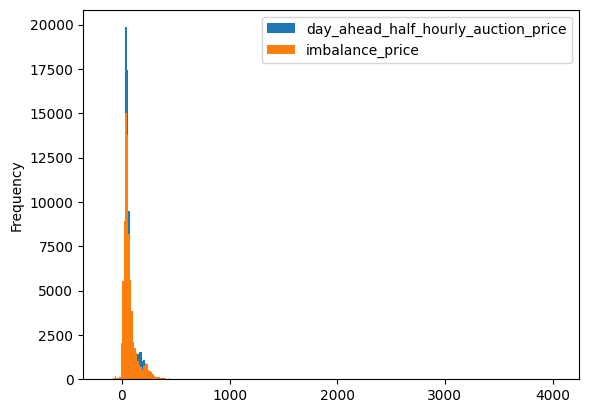

In [52]:
spot_prices[["day_ahead_half_hourly_auction_price","imbalance_price"]].plot(kind="hist",bins=300)
plt.show()

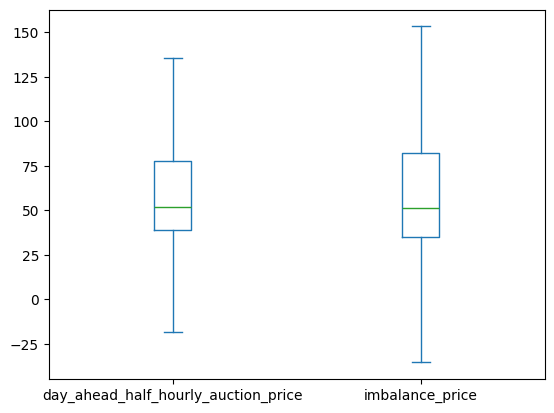

In [53]:
spot_prices[["day_ahead_half_hourly_auction_price","imbalance_price"]].plot(kind="box",showfliers=False)
plt.show()

Imabalance price has 
* a bit higher standard deviation
* roughly similar means

Both has very heavy tails and very skewed

There are some prices on both when prices are zero...
* I can confirm the one on 23rd of May 2020 through news articles
* can confirm there might be other but could not confirm what days exactly

In [54]:
(spot_prices["imbalance_price"]<0).value_counts(normalize=True)

imbalance_price
False    0.988756
True     0.011244
Name: proportion, dtype: float64

Imbalance prices can go negative, an article from Elexon said 99.7% of time it's positive. We're seing 98.9% of time which I think is fine

In [55]:
spot_prices[
    # (spot_prices["day_ahead_half_hourly_auction_price"]<0)
    # |
    (spot_prices["imbalance_price"]<0)
]["delivery_from"].dt.date.sort_values().unique()

array([datetime.date(2018, 1, 14), datetime.date(2018, 1, 29),
       datetime.date(2018, 2, 25), datetime.date(2018, 3, 2),
       datetime.date(2018, 3, 22), datetime.date(2018, 3, 28),
       datetime.date(2018, 4, 7), datetime.date(2018, 4, 26),
       datetime.date(2018, 5, 1), datetime.date(2018, 5, 2),
       datetime.date(2018, 5, 3), datetime.date(2018, 5, 4),
       datetime.date(2018, 6, 14), datetime.date(2018, 6, 16),
       datetime.date(2018, 6, 21), datetime.date(2018, 7, 27),
       datetime.date(2018, 7, 28), datetime.date(2018, 7, 31),
       datetime.date(2018, 8, 17), datetime.date(2018, 8, 18),
       datetime.date(2018, 8, 19), datetime.date(2018, 8, 22),
       datetime.date(2018, 8, 25), datetime.date(2018, 8, 27),
       datetime.date(2018, 9, 2), datetime.date(2018, 9, 10),
       datetime.date(2018, 9, 11), datetime.date(2018, 9, 16),
       datetime.date(2018, 9, 17), datetime.date(2018, 9, 18),
       datetime.date(2018, 9, 21), datetime.date(2018, 9, 22),

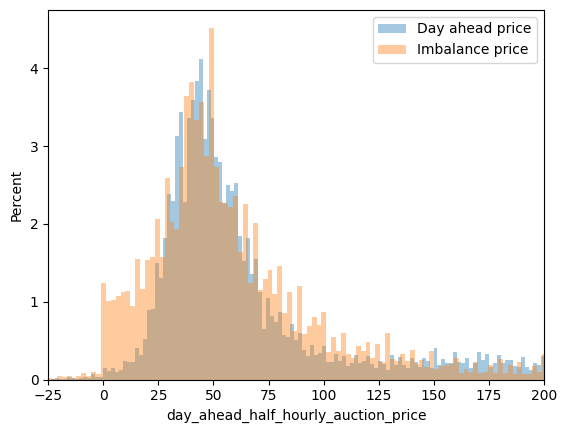

In [56]:
fig, ax = plt.subplots()
sns.histplot(
    data = spot_prices,
    x="day_ahead_half_hourly_auction_price",
    stat="percent",
    label="Day ahead price",
    ax=ax,
    edgecolor=None,
    alpha=0.4
)
sns.histplot(
    data = spot_prices,
    x="imbalance_price",
    stat="percent",
    label="Imbalance price",
    ax=ax,
    edgecolor=None,
    alpha=0.4
)
plt.xlim(-25,200)
plt.legend()
plt.show()

In [57]:
spot_prices[["day_ahead_half_hourly_auction_price","imbalance_price"]].agg(["std","mean"])

,day_ahead_half_hourly_auction_price,imbalance_price
std,71.036980,98.951113
mean,74.102158,72.715351


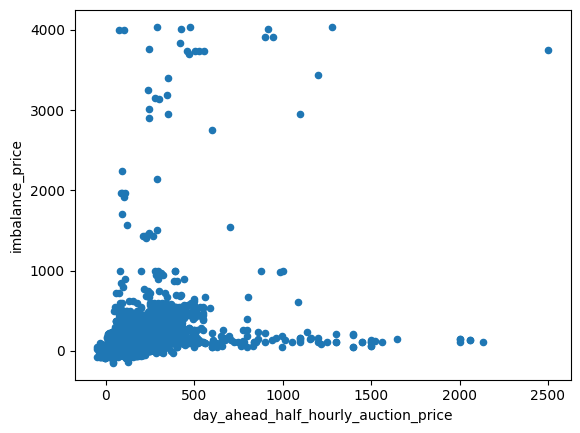

In [58]:
spot_prices[["day_ahead_half_hourly_auction_price","imbalance_price"]].plot(
    kind="scatter",
    x="day_ahead_half_hourly_auction_price",
    y="imbalance_price",
)
plt.show()

In [59]:
spot_prices[["day_ahead_half_hourly_auction_price","imbalance_price"]].corr()

,day_ahead_half_hourly_auction_price,imbalance_price
day_ahead_half_hourly_auction_price,1.000000,0.583977
imbalance_price,0.583977,1.000000


correlation between the two prices not as strong! huh!

## Trends in data

In [60]:
spot_prices.columns

Index(['delivery_from', 'day_ahead_half_hourly_auction_price',
       'imbalance_price'],
      dtype='object')

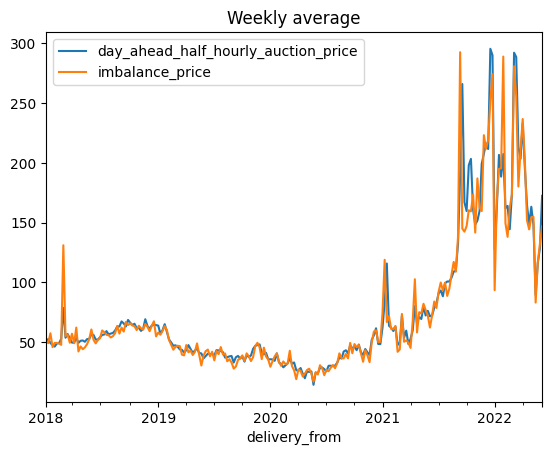

In [61]:
(
    spot_prices
    .groupby(pd.Grouper(key="delivery_from",freq="1W"))
    .mean()
).plot(kind='line')
plt.title("Weekly average")
plt.show()

Can see the change from rather stable low prices to quite high volatile prices

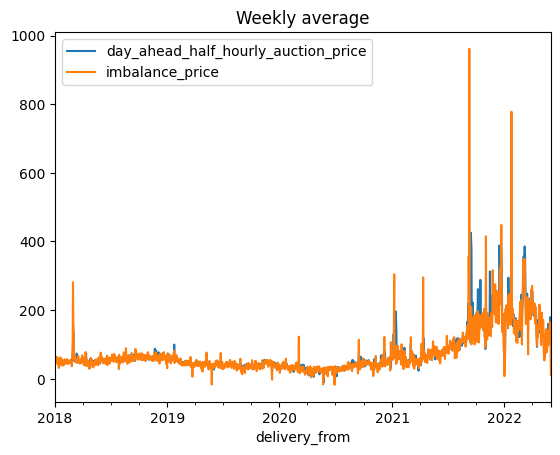

In [62]:
(
    spot_prices
    .groupby(pd.Grouper(key="delivery_from",freq="1D"))
    .mean()
).plot(kind='line')
plt.title("Weekly average")
plt.show()

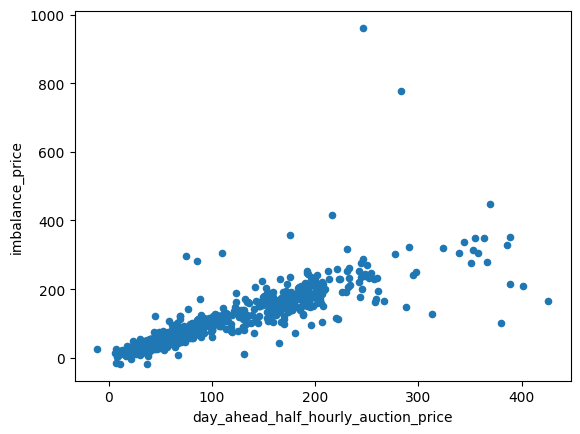

In [63]:
(
    spot_prices
    .groupby(pd.Grouper(key="delivery_from",freq="1D"))
    .mean()
).plot(kind="scatter",x="day_ahead_half_hourly_auction_price",y="imbalance_price")
plt.show()

In [64]:
(
    spot_prices
    .groupby(pd.Grouper(key="delivery_from",freq="1D"))
    .mean()
).corr()

,day_ahead_half_hourly_auction_price,imbalance_price
day_ahead_half_hourly_auction_price,1.000000,0.864183
imbalance_price,0.864183,1.000000


## daily patterns??

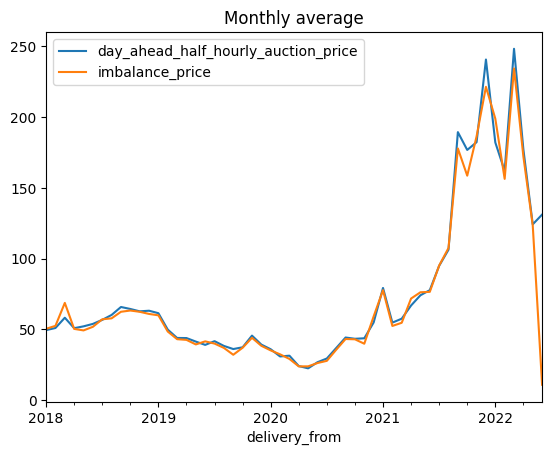

In [65]:
(
    spot_prices
    .groupby(pd.Grouper(key="delivery_from",freq="1M"))
    .mean()
).plot(kind='line')
plt.title("Monthly average")
plt.show()

In [66]:
hourly_avg_prices = spot_prices.copy()
hourly_avg_prices["hour"] = hourly_avg_prices["delivery_from"].dt.hour
hourly_avg_prices.head()

,delivery_from,day_ahead_half_hourly_auction_price,imbalance_price,hour
0,2018-01-01 00:00:00+00:00,46.73,55.94,0
1,2018-01-01 00:30:00+00:00,50.11,55.94,0
2,2018-01-01 01:00:00+00:00,56.60,62.94,1
3,2018-01-01 01:30:00+00:00,51.83,31.00,1
4,2018-01-01 02:00:00+00:00,46.23,60.81,2


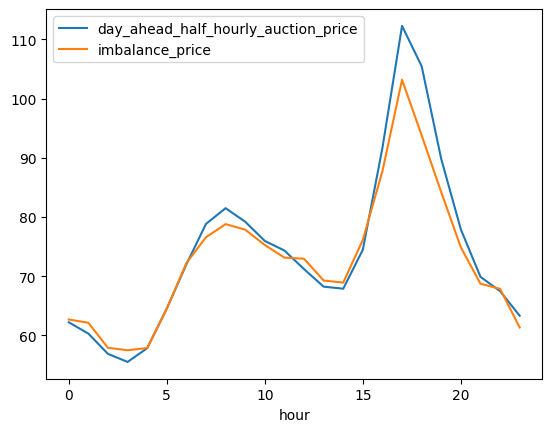

In [67]:
(
    hourly_avg_prices
    .groupby("hour")[["day_ahead_half_hourly_auction_price","imbalance_price"]]
    .mean()
    .plot(kind="line")
)
plt.show()

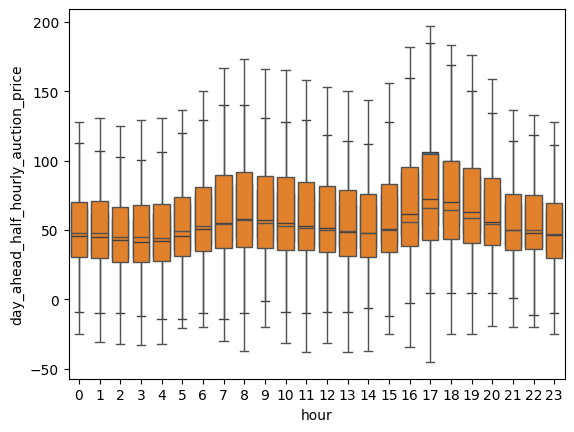

In [70]:
fig, ax = plt.subplots()
sns.boxplot(
    data=hourly_avg_prices,
    x="hour",
    y="day_ahead_half_hourly_auction_price",
    ax=ax,
    showfliers=False,
)
sns.boxplot(
    data=hourly_avg_prices,
    x="hour",
    y="imbalance_price",
    ax=ax,
    showfliers=False,
)
plt.show()

# Calculating discount

## day ahead auction price v day ahead wind forecast

In [ ]:
spot_prices.head()

,delivery_from,day_ahead_half_hourly_auction_price,imbalance_price
0,2018-01-01 00:00:00+00:00,46.73,55.94
1,2018-01-01 00:30:00+00:00,50.11,55.94
2,2018-01-01 01:00:00+00:00,56.60,62.94
3,2018-01-01 01:30:00+00:00,51.83,31.00
4,2018-01-01 02:00:00+00:00,46.23,60.81


In [ ]:
wind_forecast.head()

,delivery_from,forecast_timestamp,day_ahead_national_forecast,national_wind_capacity
115,2018-04-19 08:30:00+00:00,2018-04-19 08:04:59+00:00,2957.0,10973.0
116,2018-04-19 09:00:00+00:00,2018-04-19 08:04:59+00:00,2800.0,10973.0
117,2018-04-19 09:30:00+00:00,2018-04-19 08:04:59+00:00,2697.0,10973.0
118,2018-04-19 10:00:00+00:00,2018-04-19 08:04:59+00:00,2587.0,10973.0
119,2018-04-19 10:30:00+00:00,2018-04-19 08:04:59+00:00,2469.0,10973.0


In [71]:
day_ahead_df = pd.merge(
    spot_prices[["delivery_from","day_ahead_half_hourly_auction_price"]],
    wind_forecast[["delivery_from","day_ahead_national_forecast"]],
    on="delivery_from"
)
day_ahead_df.head()


,delivery_from,day_ahead_half_hourly_auction_price,day_ahead_national_forecast
0,2018-04-19 08:30:00+00:00,65.9,2957.0
1,2018-04-19 09:00:00+00:00,47.5,2800.0
2,2018-04-19 09:30:00+00:00,44.5,2697.0
3,2018-04-19 10:00:00+00:00,44.0,2587.0
4,2018-04-19 10:30:00+00:00,41.4,2469.0


In [72]:
day_ahead_df["wind_generated_price"] = day_ahead_df["day_ahead_half_hourly_auction_price"]*day_ahead_df["day_ahead_national_forecast"]
day_ahead_df.head()

,delivery_from,day_ahead_half_hourly_auction_price,day_ahead_national_forecast,wind_generated_price
0,2018-04-19 08:30:00+00:00,65.9,2957.0,194866.3
1,2018-04-19 09:00:00+00:00,47.5,2800.0,133000.0
2,2018-04-19 09:30:00+00:00,44.5,2697.0,120016.5
3,2018-04-19 10:00:00+00:00,44.0,2587.0,113828.0
4,2018-04-19 10:30:00+00:00,41.4,2469.0,102216.6


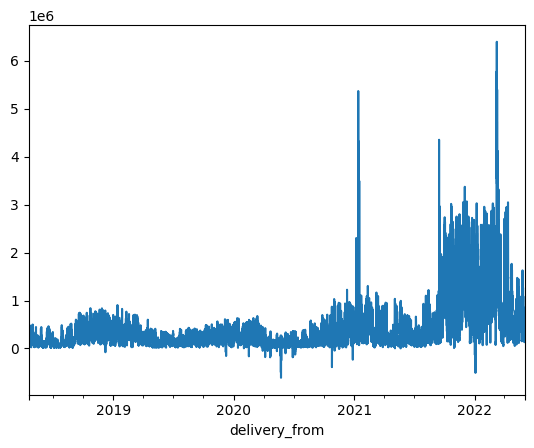

In [85]:
(
    day_ahead_df
    .groupby(pd.Grouper(key="delivery_from",freq="1h"))
    .mean()["wind_generated_price"]
    .plot(kind="line")
)
plt.show()

In [99]:
day_ahead_monthly_average = (
    day_ahead_df
    .groupby(pd.Grouper(key="delivery_from",freq="1M"))
    .agg({
        "day_ahead_half_hourly_auction_price":"mean",
        "day_ahead_national_forecast":"sum",
        "wind_generated_price":"sum"
    })
)
day_ahead_monthly_average["wind_generation_weighted_price"] = (
    day_ahead_monthly_average["wind_generated_price"]/day_ahead_monthly_average["day_ahead_national_forecast"]
)

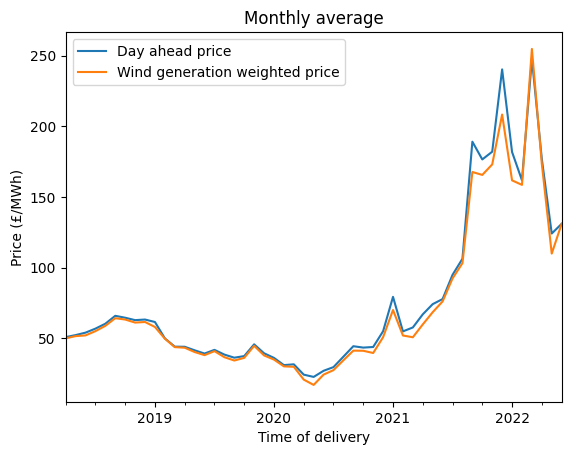

In [101]:
fig, ax = plt.subplots()
day_ahead_monthly_average[["day_ahead_half_hourly_auction_price","wind_generation_weighted_price"]].plot(kind="line",ax=ax)
plt.ylabel("Price (£/MWh)")
plt.xlabel("Time of delivery")
plt.title("Monthly average")
h,l = ax.get_legend_handles_labels()
plt.legend(handles=h,labels=["Day ahead price","Wind generation weighted price"])
plt.show()

In [95]:
day_ahead_monthly_average[["day_ahead_half_hourly_auction_price","wind_geneation_weighted_price"]].mean()

day_ahead_half_hourly_auction_price    76.421896
wind_geneation_weighted_price          72.302848
dtype: float64

So maybe the discounted price should 74.88 £/MWh... compared to the day ahead price of 76.43 £/MWh. A discount of roughly 1.5 £/MWh

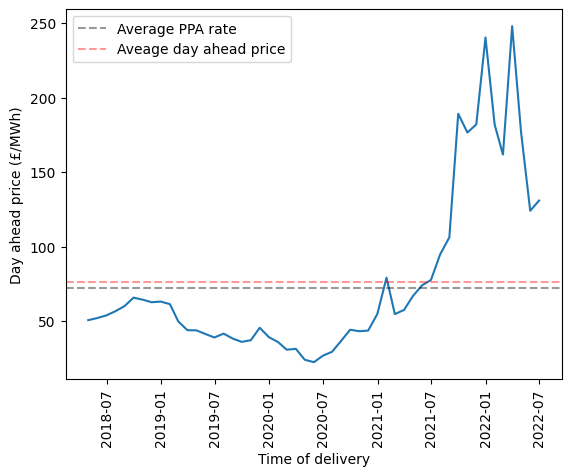

In [96]:
sns.lineplot(
    data=day_ahead_monthly_average,
    y="day_ahead_half_hourly_auction_price",
    x=day_ahead_monthly_average.index
)
plt.axhline(y=72.30,linestyle='--',color='k',alpha=0.4,label="Average PPA rate")
plt.axhline(y=76.42,linestyle='--',color='r',alpha=0.4,label="Aveage day ahead price")
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("Day ahead price (£/MWh)")
plt.xlabel("Time of delivery")
plt.show()

In [ ]:
(day_ahead_df["day_ahead_half_hourly_auction_price"]-74.88).mean()

0.8302450259455603

This is the small profit of 83p/MWh. And in total, that would have meant, if OE paid £74.88 per MWh to the wind farm and then sold onto the day ahead market, then there would be a total saving of roughly 60k in these two years!

In [ ]:
(day_ahead_df["day_ahead_half_hourly_auction_price"]-74.88).sum()

59839.08000000031

In [ ]:
(day_ahead_monthly_average["day_ahead_half_hourly_auction_price"]-74.88).mean()

1.5489739832796834

## actual wind and imbalance price

In [ ]:
spot_prices.head()

,delivery_from,day_ahead_half_hourly_auction_price,imbalance_price
0,2018-01-01 00:00:00+00:00,46.73,55.94
1,2018-01-01 00:30:00+00:00,50.11,55.94
2,2018-01-01 01:00:00+00:00,56.60,62.94
3,2018-01-01 01:30:00+00:00,51.83,31.00
4,2018-01-01 02:00:00+00:00,46.23,60.81


In [ ]:
wind_generated.head()

,delivery_from,english_wind_generated,scottish_wind_generated,total_wind_generated
0,2018-03-31 23:00:00+00:00,1680.060,614.578,2294.638
1,2018-03-31 23:30:00+00:00,1625.204,560.996,2186.200
2,2018-04-01 00:00:00+00:00,1446.452,514.734,1961.186
3,2018-04-01 00:30:00+00:00,1273.264,466.560,1739.824
4,2018-04-01 01:00:00+00:00,1387.798,387.370,1775.168


In [ ]:
day_of_df = pd.merge(
    spot_prices[["delivery_from","imbalance_price"]],
    wind_generated[["delivery_from","total_wind_generated"]],
    on="delivery_from"
)
day_of_df.head()


,delivery_from,imbalance_price,total_wind_generated
0,2018-03-31 23:00:00+00:00,68.99,2294.638
1,2018-03-31 23:30:00+00:00,59.91,2186.200
2,2018-04-01 00:00:00+00:00,42.39,1961.186
3,2018-04-01 00:30:00+00:00,54.45,1739.824
4,2018-04-01 01:00:00+00:00,57.18,1775.168


In [ ]:
day_of_df["wind_generated_price"] = day_of_df["imbalance_price"]*day_of_df["total_wind_generated"]
day_of_df.head()

,delivery_from,imbalance_price,total_wind_generated,wind_generated_price
0,2018-03-31 23:00:00+00:00,68.99,2294.638,158307.07562
1,2018-03-31 23:30:00+00:00,59.91,2186.200,130975.24200
2,2018-04-01 00:00:00+00:00,42.39,1961.186,83134.67454
3,2018-04-01 00:30:00+00:00,54.45,1739.824,94733.41680
4,2018-04-01 01:00:00+00:00,57.18,1775.168,101504.10624


In [ ]:
day_of_monthly_average = (
    day_of_df
    .groupby(pd.Grouper(key="delivery_from",freq="1M"))
    .mean()
)
day_of_monthly_average.mean()

imbalance_price             73.423349
total_wind_generated      5430.311180
wind_generated_price    388859.129782
dtype: float64

In [ ]:
388859.129782/5430.311180

71.60899567122044

So maybe the discounted price should 71.61 £/MWh, compared to an average imbalance price of £73.42. So a discoutn fo 1.8 £/MWh
Using imbalance prices gives you a slightly higher discount amount but the average price paid is lower... 

In [ ]:
73.423349 - 388859.129782/5430.311180

1.8143533287795606

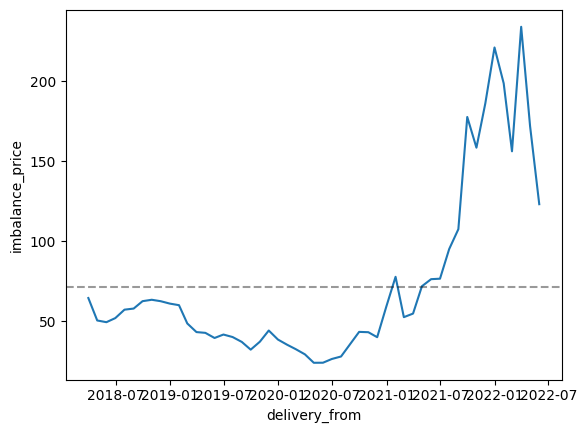

In [ ]:
sns.lineplot(
    data=day_of_monthly_average,
    y="imbalance_price",
    x=day_of_monthly_average.index
)
plt.axhline(y=71.61,linestyle='--',color='k',alpha=0.4)
plt.show()

In [ ]:
(day_of_df["imbalance_price"]-71.61).mean()

1.970977564102561

Quite a large prices.... And in total, that would have meant, if OE paid 71.61 £/MWh to the wind farm instead of paying hte imbalance price, that would be a saving of £154k in these two years! JEEEZ a lot higher!!!

In [ ]:
(day_of_df["imbalance_price"]-71.61).sum()

143897.12999999977

In [ ]:
(day_of_monthly_average["imbalance_price"]-71.61).mean()

1.813349463435602